In [1]:
from nufeb_tools import utils,plot
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import find_peaks
from scipy.spatial.distance import pdist,squareform
from scipy.spatial import KDTree
from scipy.spatial import Voronoi, voronoi_plot_2d
import skgeom as sg
from tqdm import tqdm

In [2]:
low = utils.get_data(directory= r'D:\runs\Run_50_50_10_1_2021-07-27')
med = utils.get_data(directory= r'D:\runs\Run_50_50_45_1_2021-07-27')
high = utils.get_data(directory= r'D:\runs\Run_50_50_100_1_2021-07-27')

In [3]:
_ = [x.count_colony_area(35000) for x in [low, med, high]]

Assigning ancestry: 100%|██████████| 350/350 [01:58<00:00,  2.96it/s]


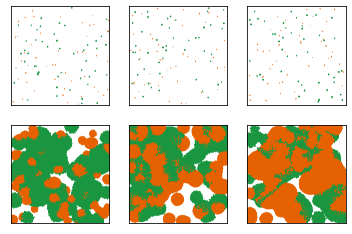

In [4]:
f,axes = plt.subplots(nrows=2,ncols=3)
for ax, x in zip(axes.ravel()[:3],[low,med,high]):
    plot.colony(x,0,by='Species',ax=ax)
for ax, x in zip(axes.ravel()[3:],[low,med,high]):
    plot.colony(x,35000,by='Species',ax=ax)
plt.show()
f.tight_layout()

In [5]:
df = high.colonies.copy()
# calculate voronoi area
dfs = list()
for type_ in df.type.unique():
    IDs = df[(df.Timestep ==0) & (df.type == type_)][['mother_cell','type']]
    points = df[(df.Timestep ==0) & (df.type == type_)][['x','y']].values
    vor = Voronoi(points)
    areas = [abs(float(sg.Polygon(vor.vertices[vor.regions[i]]).area())) for i in range(len(vor.regions))]
    IDs['Voronoi Area'] = areas[1:]
    dfs.append(IDs)
metrics = pd.concat(dfs)

# total biomass per colony
biomasses = df[df.Timestep==35000].groupby('mother_cell').sum().reset_index()[['mother_cell','biomass']]
biomasses.columns=['mother_cell','total biomass']

# Calculate nearest neighbors
df3 = df[df.Timestep == 0]
arr1 = df3[df3.type==1][['x','y','z']].to_numpy()
tree1 = KDTree(arr1)
d1, i1 = tree1.query(df3[['x','y','z']].to_numpy(), k=2)
arr2 = df3[df3.type==2][['x','y','z']].to_numpy()
tree2 = KDTree(arr2)
d2, i2 = tree2.query(df3[['x','y','z']].to_numpy(), k=2)
idx1 =df3.index
n1 = list()
n2 = list()
for i in range(len(d1)):
    if d1[i,0]==0:
        n1.append(d1[i,1])
    else:
        n1.append(d1[i,0])
for i in range(len(d2)):
    if d2[i,0]==0:
        n2.append(d2[i,1])
    else:
        n2.append(d2[i,0])
df3['Nearest1']=n1
df3['Nearest2']=n2
df3 = df3[['mother_cell','Nearest1','Nearest2']]
# calculate sum of inverse neighbor distance
inv1 = list()
for i in df[df.Timestep == 0][['x','y','z']].to_numpy():
    d1, i1 = tree1.query(i,k=2)
    if d1[0]==0:
        inv1.append(np.sum(1/d1[1]))
    else:
        inv1.append(np.sum(1/d1[0]))
inv2 = list()
inv3 = list()
for i in df[df.Timestep == 0][['x','y','z']].to_numpy():
    d2, i2 = tree2.query(i,k=2)
    if d2[0]==0:
        inv2.append(np.sum(1/d2[1]))
    else:
        inv2.append(np.sum(1/d2[0]))
# Calculate log inverse squared neighbor distance
log_inv1 = list()
for i in df[df.Timestep == 0][['x','y','z']].to_numpy():
    d1, i1 = tree1.query(i,k=2)
    if d1[0]==0:
        log_inv1.append(np.log(np.sum(1/(d1[1]**2))))
    else:
        log_inv1.append(np.log(np.sum(1/(d1[0]**2))))
log_inv2 = list()
for i in df[df.Timestep == 0][['x','y','z']].to_numpy():
    d2, i2 = tree2.query(i,k=2)
    if d2[0]==0:
        log_inv2.append(np.log(np.sum(1/(d2[1]**2))))
    else:
        log_inv2.append(np.log(np.sum(1/(d2[0]**2))))

df3['Inv1']=inv1
df3['Inv2']=inv2
df3['Log Inv1']=log_inv1
df3['Log Inv2']=log_inv2


#df[df.Timestep==0]
metrics = metrics.merge(biomasses,on='mother_cell')#.groupby('mother_cell').max().reset_index()
metrics = metrics.merge(df3,on='mother_cell')
metrics

<ipython-input-5-2e606edfc596>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Nearest1']=n1
<ipython-input-5-2e606edfc596>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Nearest2']=n2


,mother_cell,type,Voronoi Area,total biomass,Nearest1,Nearest2,Inv1,Inv2,Log Inv1,Log Inv2
0,1,1,8.176736e-11,87938.767091,0.000009,0.000009,116598.830739,115934.646027,23.332989,23.321564
1,38,1,9.429747e-10,39199.040701,0.000008,0.000024,119844.217478,41421.857718,23.387896,21.263128
2,33,1,4.815624e-10,58187.840650,0.000007,0.000017,141463.801746,58941.694408,23.719598,21.968608
3,17,1,3.552387e-10,128587.923442,0.000007,0.000011,141463.801746,94551.752121,23.719598,22.913805
4,15,1,1.147650e-10,105116.257087,0.000009,0.000010,116598.830739,95396.572203,23.332989,22.931596
...,...,...,...,...,...,...,...,...,...,...
85,76,2,1.458823e-10,184982.435108,0.000017,0.000003,58778.100716,323463.718366,21.963049,25.373684
86,82,2,4.530585e-10,706685.314930,0.000017,0.000003,57913.628028,323463.718366,21.933416,25.373684
87,96,2,3.006473e-10,869894.608965,0.000011,0.000009,93504.344177,116236.565382,22.891526,23.326766
88,70,2,1.411027e-10,353571.286073,0.000014,0.000009,70899.718363,106822.488573,22.338043,23.157848


In [6]:
metric2 = metrics[metrics.type==2]
import statsmodels.api as sm
x_columns = ['Voronoi Area','Nearest1','Nearest2','Inv1','Inv2','Log Inv1','Log Inv2']
y = metric2['total biomass']
def get_stats():
    x = metric2[x_columns]
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats()

                                 OLS Regression Results                                
Dep. Variable:          total biomass   R-squared (uncentered):                   0.744
Model:                            OLS   Adj. R-squared (uncentered):              0.694
Method:                 Least Squares   F-statistic:                              14.96
Date:                Tue, 07 Sep 2021   Prob (F-statistic):                    5.74e-09
Time:                        10:49:13   Log-Likelihood:                         -571.34
No. Observations:                  43   AIC:                                      1157.
Df Residuals:                      36   BIC:                                      1169.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [7]:
metric2.reset_index(drop=True,inplace=True)

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ['Voronoi Area','Nearest1','Nearest2','Inv1','Inv2','Log Inv1','Log Inv2','total biomass']# Separating out the features
x = metric2.loc[:, features].values# Separating out the target
y = metric2.loc[:,['total biomass']].values# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, metric2[['total biomass']]], axis = 1)


In [9]:
scaler = StandardScaler()
x = scaler.fit(metric2)
x

StandardScaler()

<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

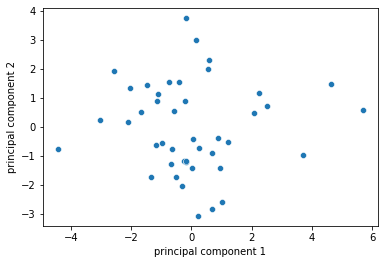

In [10]:
sns.scatterplot(x='principal component 1', y= 'principal component 2',data=finalDf)

<AxesSubplot:xlabel='Timestep', ylabel='mother_cell'>

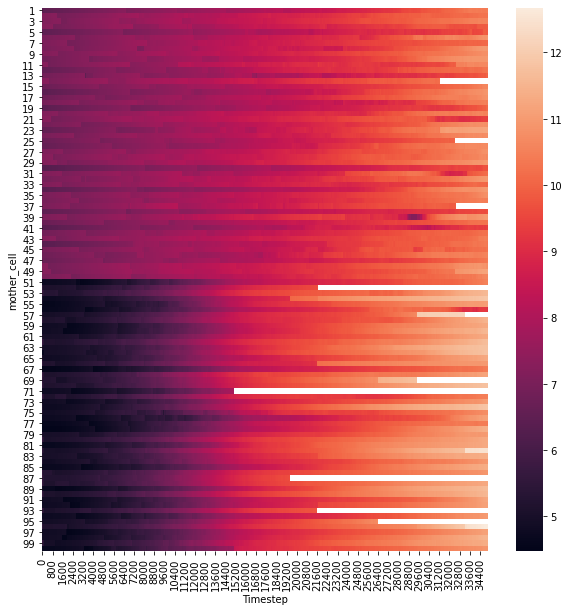

In [11]:
# TODO find missing colonies

data = df.copy()
data['sum'] = df.groupby(['mother_cell','Timestep'])['biomass'].cumsum()
data['sum'] = np.log(data['sum'])
pivs = data.pivot_table(index='mother_cell', columns='Timestep', values='sum')
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pivs,ax=ax)


<AxesSubplot:xlabel='Timestep', ylabel='ID'>

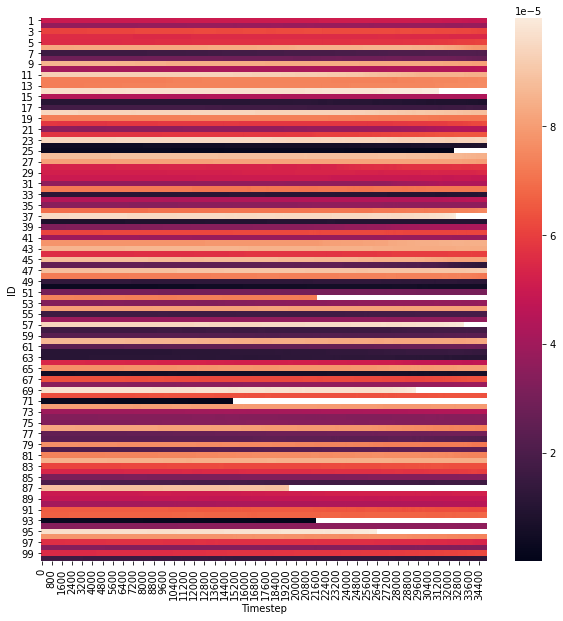

In [12]:
data2 = high.positions.copy()

pivs2 = data2[data2.ID <= 100].pivot_table(index='ID',columns = 'Timestep',values='x')
#data2.loc[IDs,'x']
#data2['sum'] = data2.groupby(['mother_cell','Timestep'])['biomass'].cumsum()
#data2['sum'] = np.log(data2['sum'])
#pivs2 = data2.pivot_table(index='mother_cell', columns='Timestep', values='sum')
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pivs2,ax=ax)

In [13]:
data2[(data2.ID ==189)]

,Timestep,ID,type,radius,x,y,z,biomass,time,mother_cell,Colony Area
3766,2300,189,2,4.149427e-07,0.000003,0.000070,0.000009,68.830483,6.388889,71,NaN
3955,2400,189,2,4.166894e-07,0.000003,0.000070,0.000009,69.703387,6.666667,71,NaN
4147,2500,189,2,4.185115e-07,0.000003,0.000070,0.000009,70.621769,6.944444,71,NaN
4339,2600,189,2,4.204090e-07,0.000003,0.000070,0.000009,71.586702,7.222222,71,NaN
4534,2700,189,2,4.223821e-07,0.000003,0.000070,0.000009,72.599370,7.500000,71,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7902609,34600,189,2,4.081998e-07,0.000005,0.000072,0.000005,65.529173,96.111111,100,NaN
8011851,34700,189,2,4.093761e-07,0.000005,0.000073,0.000005,66.097309,96.388889,100,NaN
8122471,34800,189,2,4.105521e-07,0.000005,0.000073,0.000005,66.668611,96.666667,100,NaN
8234495,34900,189,2,4.117309e-07,0.000005,0.000073,0.000005,67.244521,96.944444,100,NaN


In [14]:
df = high.positions.copy()
df['mother_cell'] = -1
for ID in df[df.Timestep==0].ID.unique():
    idx = df[df['ID'] ==ID].index
    df.loc[idx,'mother_cell'] = ID

#for time in tqdm(sorted(df[df.Timestep!=0].Timestep.unique()),desc='Assigning ancestry'):
for time in ([100,1000,10000]):
    for type_ in df.type.unique():
        ancestors = df[(df.type==type_) & (df.Timestep==time) & (df.mother_cell != -1)]
        arr1 = ancestors[['x','y','z']].to_numpy()
        tree1 = KDTree(arr1)
        motherless = df[(df.type==type_) & (df.Timestep==time) & (df.mother_cell == -1)]
        if not motherless.empty:
            d, i = tree1.query(motherless[['x','y','z']].to_numpy(), k=1)
            idx1 =motherless.index
            a = ancestors.iloc[i,:].mother_cell.values
            df.loc[idx1,'mother_cell']=a
            #for ID in motherless.ID:
               # df.loc[df.ID==ID,'mother_cell'] = df[(df.Timestep ==time) & (df.ID==ID)]

In [15]:
temp =df[df.ID.isin(motherless.ID)].copy()
for t in ([100,1000,10000]):
    print(temp.loc[temp.Timestep==t,'mother_cell'])


126    62
127    58
128    74
129    63
130    53
144    61
145    55
146    90
157    93
158    86
159    80
160    75
161    88
162    68
163    89
164    66
177    83
178    87
179    52
180    54
194    79
195    84
196    99
197    65
198    72
199    81
211    82
212    57
213    69
214    96
215    70
231    95
Name: mother_cell, dtype: int64
1477    62
1481    62
1484    58
1490    74
1492    53
1495    53
1496    63
1502    61
1505    55
1511    90
1513    90
1516    90
1517    93
1518    80
1520    80
1521    86
1523    93
1524    88
1525    86
1526    86
1529    68
1532    68
1534    80
1535    75
1536    89
1537    88
1539    68
1541    66
1542    66
1545    83
1553    52
1554    87
1555    87
1557    87
1562    54
1567    64
1568    79
1569    99
1570    84
1576    99
1577    72
1578    65
1580    81
1581    72
1585    82
1586    69
1589    57
1591    82
1593    70
1594    69
1596    96
1598    70
1617    95
Name: mother_cell, dtype: int64
37196    78
37197    78
37203    

In [16]:
temp[temp.Timestep==5000].ID.unique()

array([233, 276, 211, 176, 133, 216, 243, 242, 192, 101, 102, 175, 265,
       171, 195, 103, 249, 167, 223, 181, 105, 134, 224, 246, 259, 104,
       212, 196, 206, 106, 266, 213, 221, 107, 277, 136, 108, 247, 189,
       135, 137, 111, 227, 267, 197, 113, 110, 141, 142, 109, 157, 268,
       143, 234, 207, 183, 250, 112, 269, 254, 114, 270, 235, 115, 236,
       140, 253, 138, 255, 139, 278, 116, 144, 198, 202, 260, 117, 177,
       186, 229, 119, 146, 252, 199, 145, 251, 118, 261, 194, 244, 120,
       262, 219, 173, 208, 237, 149, 271, 121, 123, 122, 238, 225, 125,
       147, 178, 239, 240, 124, 241, 228, 279, 126, 148, 280, 272, 150,
       214, 263, 162, 200, 129, 226, 128, 222, 127, 131, 182, 273, 160,
       201, 130, 184, 151, 231, 174, 217, 132])

In [17]:
def fitness_metrics(obj):
    df = obj.colonies.copy()

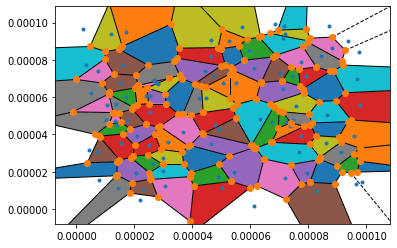

In [18]:

df = low.colonies
df = df[(df.Timestep ==0)][['x','y']]
points = df.values
vor = Voronoi(points)


#ax.plot(points[:,0], points[:,1], 'ko')
#ax.axis('equal')
ax.set_xlim(0, 1e-4)
ax.set_ylim(0, 1e-4)


#plt.show()
voronoi_plot_2d(vor)
    # colorize
for region in vor.regions:
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon))

In [19]:
areas = [abs(float(sg.Polygon(vor.vertices[vor.regions[i]]).area())) for i in range(len(vor.regions))]
areas

[5.927561114151109e-10,
 2.25029972863217e-10,
 2.0788058240223975e-09,
 0.0,
 1.152659687776903e-09,
 1.045190257839682e-10,
 2.8583516246319814e-10,
 2.1643157166143973e-10,
 6.182522249682973e-11,
 1.573275715208619e-09,
 2.1300643661018328e-10,
 3.1363831508169893e-10,
 1.4695121878969986e-10,
 1.3471068982701513e-08,
 2.6101909679608275e-10,
 5.377414661891362e-11,
 1.0002691160507039e-10,
 3.558304608420969e-08,
 1.0561295876297749e-10,
 7.885981553523601e-11,
 6.909014871963881e-11,
 4.141596684391545e-11,
 3.722982487428086e-10,
 8.46597348884112e-10,
 1.4506366243276525e-10,
 1.3790148409466636e-10,
 3.8493066470158526e-11,
 7.02232215883538e-11,
 1.3511665083535565e-10,
 8.30996234944902e-11,
 9.6644796907021e-11,
 4.98214033560005e-11,
 1.1740040295833826e-10,
 1.2471252122032506e-10,
 7.867081317005466e-11,
 4.155650114732805e-11,
 2.2312063832666177e-11,
 8.561692757853804e-11,
 7.078081081964076e-11,
 1.8371789211861683e-09,
 2.0991784903326158e-10,
 5.114900427273522e-09

In [20]:
low.colonies.loc[low.colonies.Timestep==0,'Voronoi Area'] = pd.Series(areas)

In [21]:
biomasses = low.colonies[low.colonies.Timestep==35000].groupby('mother_cell').sum().reset_index()[['mother_cell','biomass']]
biomasses.columns=['mother_cell','total biomass']

In [22]:
df = pd.merge(low.colonies,biomasses,on='mother_cell').groupby('mother_cell').max().reset_index()
df.head()

,mother_cell,Timestep,ID,type,radius,x,y,z,biomass,time,Colony Area,Voronoi Area,total biomass
0,1,35000,37493,1,9.852695e-07,0.000084,0.000053,0.000009,1482.366037,97.222222,55415.0,8.184528e-11,250344.490205
1,2,35000,37489,1,9.852502e-07,0.000096,0.000038,0.000009,1482.278816,97.222222,19637.0,1.926363e-09,127521.965465
2,3,35000,37500,1,9.852609e-07,0.000079,0.000079,0.000009,1482.327417,97.222222,26160.0,7.077862e-11,254730.268939
3,4,35000,37509,1,9.852690e-07,0.000092,0.000071,0.000009,1482.363563,97.222222,65277.0,2.880012e-10,260207.573994
4,5,35000,37506,1,9.852717e-07,0.000078,0.000074,0.000009,1482.375738,97.222222,88503.0,4.239826e-08,282925.655142


In [23]:
df2 = low.positions[low.positions.Timestep == 0]
arr = df2[['x','y','z']].to_numpy()
tree = KDTree(arr)
d, i = tree.query(arr, k=2)
d[:,1],i[:,1]
idx1 =df2.index
df2.loc[idx1,'NN']=d[:,1]
df2 = df2[['mother_cell','NN']]

C:\Users\Jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\Jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [24]:
df3 = low.positions[low.positions.Timestep == 0]
arr1 = df3[df3.type==1][['x','y','z']].to_numpy()
tree1 = KDTree(arr1)
d1, i1 = tree1.query(df3[['x','y','z']].to_numpy(), k=2)
arr2 = df3[df3.type==2][['x','y','z']].to_numpy()
tree2 = KDTree(arr2)
d2, i2 = tree2.query(df3[['x','y','z']].to_numpy(), k=2)
idx1 =df3.index
n1 = list()
n2 = list()
for i in range(len(d1)):
    if d1[i,0]==0:
        n1.append(d1[i,1])
    else:
        n1.append(d1[i,0])
for i in range(len(d2)):
    if d2[i,0]==0:
        n2.append(d2[i,1])
    else:
        n2.append(d2[i,0])
df3.loc[idx1,'Nearest1']=n1
df3.loc[idx1,'Nearest2']=n2
df3 = df3[['mother_cell','Nearest1','Nearest2']]

C:\Users\Jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\Jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [25]:
inv1 = list()
for i in low.positions[low.positions.Timestep == 0][['x','y','z']].to_numpy():
    d1, i1 = tree1.query(i,k=2)
    if d1[0]==0:
        inv1.append(np.sum(1/d1[1]))
    else:
        inv1.append(np.sum(1/d1[0]))
inv2 = list()
inv3 = list()
for i in low.positions[low.positions.Timestep == 0][['x','y','z']].to_numpy():
    d2, i2 = tree2.query(i,k=2)
    if d2[0]==0:
        inv2.append(np.sum(1/d2[1]))
    else:
        inv2.append(np.sum(1/d2[0]))
    #


In [26]:
n3 = list()
for i,j in zip(n1,n2):
    n3.append(i-j)


In [27]:
log_inv1 = list()
for i in low.positions[low.positions.Timestep == 0][['x','y','z']].to_numpy():
    d1, i1 = tree1.query(i,k=2)
    if d1[0]==0:
        log_inv1.append(np.log(np.sum(1/(d1[1]**2))))
    else:
        log_inv1.append(np.log(np.sum(1/(d1[0]**2))))
log_inv2 = list()
for i in low.positions[low.positions.Timestep == 0][['x','y','z']].to_numpy():
    d2, i2 = tree2.query(i,k=2)
    if d2[0]==0:
        log_inv2.append(np.log(np.sum(1/(d2[1]**2))))
    else:
        log_inv2.append(np.log(np.sum(1/(d2[0]**2))))

In [28]:
df3.loc[idx1,'Inv1']=inv1
df3.loc[idx1,'Inv2']=inv2
df3.loc[idx1,'Log Inv1']=log_inv1
df3.loc[idx1,'Log Inv2']=log_inv2
df3.loc[idx1,'Net NN']=n3

In [29]:
df3

,mother_cell,Nearest1,Nearest2,Inv1,Inv2,Log Inv1,Log Inv2,Net NN
0,94,0.000010,0.000008,97128.586236,130130.916394,22.967582,23.552593,2.611061e-06
1,39,0.000013,0.000004,74752.843523,268811.376854,22.443885,25.003530,9.657337e-06
2,52,0.000004,0.000008,268811.376854,130130.916394,25.003530,23.552593,-3.964488e-06
3,33,0.000008,0.000009,118351.151635,109755.995542,23.362823,23.212030,-6.616876e-07
4,9,0.000008,0.000010,130929.537077,101677.064186,23.564829,23.059114,-2.197364e-06
...,...,...,...,...,...,...,...,...
95,65,0.000009,0.000011,105337.650074,94293.100188,23.129852,22.908327,-1.111948e-06
96,98,0.000008,0.000007,120237.042921,150162.846055,23.394441,23.838951,1.657468e-06
97,22,0.000008,0.000002,130590.596827,414652.289318,23.559645,25.870391,5.245860e-06
98,85,0.000008,0.000007,119910.972771,152013.431771,23.389010,23.863448,1.761154e-06


In [30]:
df = pd.merge(df,df2,on='mother_cell').groupby('mother_cell').max().reset_index()
df = pd.merge(df,df3,on='mother_cell').groupby('mother_cell').max().reset_index()
df.head()

,mother_cell,Timestep,ID,type,radius,x,y,z,biomass,time,...,Voronoi Area,total biomass,NN,Nearest1,Nearest2,Inv1,Inv2,Log Inv1,Log Inv2,Net NN
0,1,35000,37493,1,9.852695e-07,0.000084,0.000053,0.000009,1482.366037,97.222222,...,8.184528e-11,250344.490205,0.000003,0.000007,0.000003,149962.963721,338400.271532,23.836287,25.463969,3.713233e-06
1,2,35000,37489,1,9.852502e-07,0.000096,0.000038,0.000009,1482.278816,97.222222,...,1.926363e-09,127521.965465,0.000009,0.000009,0.000011,113774.478359,95156.610473,23.283947,22.926559,-1.719674e-06
2,3,35000,37500,1,9.852609e-07,0.000079,0.000079,0.000009,1482.327417,97.222222,...,7.077862e-11,254730.268939,0.000005,0.000009,0.000005,110295.153756,211354.150258,23.221831,24.522581,4.335186e-06
3,4,35000,37509,1,9.852690e-07,0.000092,0.000071,0.000009,1482.363563,97.222222,...,2.880012e-10,260207.573994,0.000008,0.000008,0.000012,118584.254213,82749.792417,23.366758,22.647154,-3.651800e-06
4,5,35000,37506,1,9.852717e-07,0.000078,0.000074,0.000009,1482.375738,97.222222,...,4.239826e-08,282925.655142,0.000008,0.000009,0.000008,110295.153756,119419.181851,23.221831,23.380790,6.927174e-07


<AxesSubplot:xlabel='total biomass', ylabel='Net NN'>

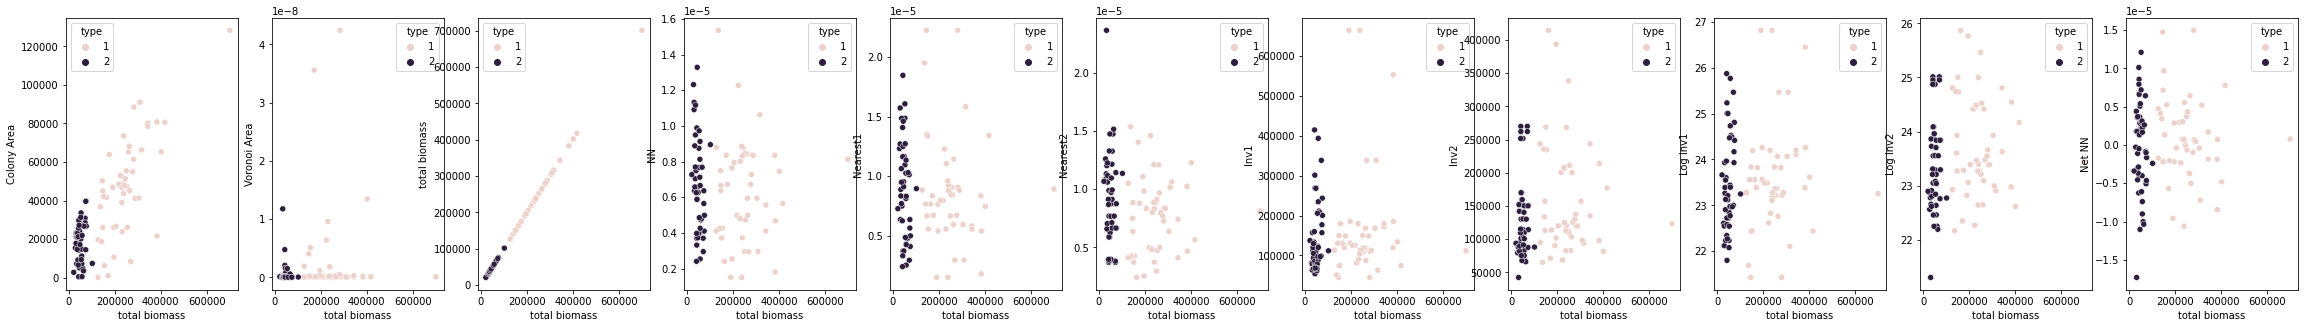

In [31]:
f, axes = plt.subplots(ncols=11,figsize=(40,5))
sns.scatterplot(x='total biomass',y='Colony Area',hue='type',data=df,ax=axes[0])
sns.scatterplot(x='total biomass',y='Voronoi Area',hue='type',data=df,ax=axes[1])
sns.scatterplot(x='total biomass',y='total biomass',hue='type',data=df,ax=axes[2])
sns.scatterplot(x='total biomass',y='NN',hue='type',data=df,ax=axes[3])
sns.scatterplot(x='total biomass',y='Nearest1',hue='type',data=df,ax=axes[4])
sns.scatterplot(x='total biomass',y='Nearest2',hue='type',data=df,ax=axes[5])
sns.scatterplot(x='total biomass',y='Inv1',hue='type',data=df,ax=axes[6])
sns.scatterplot(x='total biomass',y='Inv2',hue='type',data=df,ax=axes[7])
sns.scatterplot(x='total biomass',y='Log Inv1',hue='type',data=df,ax=axes[8])
sns.scatterplot(x='total biomass',y='Log Inv2',hue='type',data=df,ax=axes[9])
sns.scatterplot(x='total biomass',y='Net NN',hue='type',data=df,ax=axes[10])
#for ax in axes.ravel():
   # ax.set_xscale('log')
   # ax.set_yscale('log')


In [32]:
def lin_func(x,m,b):
    return m*x + b
from scipy import stats
for metric in ['Colony Area','Voronoi Area','total biomass','NN','Nearest1','Nearest2','Inv1','Inv2','Log Inv1','Log Inv2','Net NN']:
    x = df['total biomass']
    y = df[metric]
    res = stats.linregress(x, y)
    print(res.rvalue)
    #y_fit = lin_func(x,res.slope,res.intercept)

0.7906406216012511
0.11950566422758872
1.0
-0.08348340267164557
-0.1110621943231021
-0.1557569474528226
0.10581379749015286
0.08845034945274036
0.11075139641983651
0.12249775313424506
0.014696878103631987
